# 🤖 Bertopic with abstracts of *Biology and Philosophy* 

In [30]:
# Packages to import. 
import pandas as pd 
import numpy as np
import datamapplot
import pandas as pd 
import os

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP


## 📄 Data
This data is from *Biology and Philosophy* journal from 1986 to 2023. I removed all the entries with no abstract. 


In [31]:
base_dir = "C:\\Users\\jacob\\OneDrive - Université Laval\\biophilo\\Data\\pybiblio\\SPECIALIZED PHILOSOPHY OF BIOLOGY\\"
data = "ARTICLES_SPECIAL_PHILO_BIO.csv"
file_path = os.path.join(base_dir, data)

df = pd.read_csv(base_dir + data)
df


...1                 eid                         doi  pii  pubmed_id  \
0        0  2-s2.0-85214130018  10.1007/s10539-024-09975-9  NaN        NaN   
1        1  2-s2.0-85213705399  10.1007/s10539-024-09978-6  NaN        NaN   
2        2  2-s2.0-85213504854  10.1007/s10539-024-09977-7  NaN        NaN   
3        3  2-s2.0-85212923885  10.1007/s10539-024-09976-8  NaN        NaN   
4        4  2-s2.0-85211818588  10.1007/s10539-024-09974-w  NaN        NaN   
...    ...                 ...                         ...  ...        ...   
4282    59  2-s2.0-51649148197          10.1007/BF02423834  NaN        NaN   
4283    60  2-s2.0-51249172897          10.1007/BF02423832  NaN        NaN   
4284    61  2-s2.0-51249171339          10.1007/BF02423831  NaN        NaN   
4285    62   2-s2.0-2342585303          10.1007/BF02426629  NaN        NaN   
4286    63   2-s2.0-0002459750          10.1007/BF02426630  NaN        NaN   

                                                  title subtype  \
0     Interventionism as a dangerously anthropocentr...      ar   
1     Defending the importance of lineage-forming re...      ar   
2     The gradational nature of biological functions...      ar   
3     Correction to: A co-constitutive analysis of i...      er   
4     Correction to: Cultural intelligence, shared i...      er   
...                                                 ...     ...   
4282  Marxism and human sociobiology: A reply to Zha...      re   
4283  Species of thought: A comment on evolutionary ...      ar   
4284  Modeling in the museum: On the role of remnant...      ar   
4285    Does evolutionary biology contribute to ethics?      ar   
4286        The crucial experiment of Wilhelm Johannsen      ar   

     subtypeDescription         creator                afid  ... pageRange  \
0               Article     Koperski P.            60110624  ...       NaN   
1               Article        Zhang M.            60009860  ...       NaN   
2               Article       Šustar P.            60077673  ...       NaN   
3               Erratum  McConwell A.K.            60033461  ...       NaN   
4               Erratum        Koreň L.            60000474  ...       NaN   
...                 ...             ...                 ...  ...       ...   
4282             Review        Keita L.            60072930  ...     79-83   
4283            Article       Wilson D.            60020273  ...     37-62   
4284            Article    Griesemer J.            60014439  ...      3-36   
4285            Article      Bateson P.            60031101  ...   287-301   
4286            Article  Roll-Hansen N.  60010348;100444942  ...   303-329   

                                            description  \
0     The article presents and critically discusses ...   
1     Charbonneau (2014) and Papale (2021) challenge...   
2     In this paper, we consider whether a straightf...   
3     In the sentence beginning “Case 3 Rerun. And f...   
4     Cultural intelligence, shared intentionality a...   
...                                                 ...   
4282                                                NaN   
4283  The primary outcome of natural selection is ad...   
4284  Accounts of the relation between theories and ...   
4285  Human propensities that are the products of Da...   
4286  I call an experiment "crucial" when it makes p...   

                                           authkeywords  citedby_count  \
0     Animal suffering | Anthropocene | Environmenta...              0   
1     Ecological inheritance | Evolution by natural ...              0   
2     Causal role | de novo genes | Genome biology |...              0   
3                                                   NaN              0   
4                                                   NaN              0   
...                                                 ...            ...   
4282  economic growth | free-market economies | Marx...              2   
4283  adaptation | Evoluti

In [32]:

filtered_df = df[df["subtypeDescription"] == "Article"]
filtered_df['abstract'] = filtered_df.description.dropna()

In [33]:
newdf = filtered_df.dropna(subset=['abstract', 'author_names']) 

In [34]:
docs = newdf.abstract.to_list()

# New column for visualization purposes. 
columns_to_combine = ['author_names', 'coverDate', 'title']
newdf['combined'] = newdf[columns_to_combine].apply(lambda row: ', '.join(map(str, row)), axis=1)
node_text = newdf.combined.to_list()

## 🦙 Import Llama for labels

In [35]:
from llama_cpp import Llama

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path="C:/Users/jacob/OneDrive/Bureau/openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"])

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from C:/Users/jacob/OneDrive/Bureau/openhermes-2.5-mistral-7b.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = teknium_openhermes-2.5-mistral-7b
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_load

In [36]:
from bertopic.representation import KeyBERTInspired, LlamaCPP

prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

## 🌌 BERTopic model

In [37]:
# Pre-calculate embeddings
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine', random_state=30).fit_transform(embeddings)

Batches:   0%|          | 0/101 [00:00<?, ?it/s]

In [80]:
# Define sub-models
from hdbscan import HDBSCAN
from umap import UMAP
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine', random_state=30)
hdbscan_model = HDBSCAN(min_cluster_size=18, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

## Visualisation Without Llama

In [81]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Define a list of stopwords (or use an extended one)
vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(
  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  #representation_model=representation_model, # This line would be uncommented if we wanted to use llama. 
  vectorizer_model=vectorizer_model,
  
  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)



2025-04-21 15:38:10,895 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-21 15:38:21,591 - BERTopic - Dimensionality - Completed ✓
2025-04-21 15:38:21,592 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-21 15:38:21,654 - BERTopic - Cluster - Completed ✓
2025-04-21 15:38:21,656 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-04-21 15:38:21,982 - BERTopic - Representation - Completed ✓


In [83]:
# Count how many are labeled -1 (outliers)

topic_info = topic_model.get_topic_info()
outlier_count = topic_info[topic_info['Topic'] == -1]['Count'].values[0]
print(f"Number of outliers: {outlier_count}")

Number of outliers: 1344


In [84]:
topic_model.visualize_heatmap()

In [49]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchical_documents(docs, hierarchical_topics, reduced_embeddings=reduced_embeddings)

100%|██████████| 47/47 [00:00<00:00, 387.31it/s]


In [77]:
x = topic_model.get_document_info(docs)
y = x.Name
labels =y.values
labels.shape
labels

array(['15_conservation_biodiversity_invasion_environmental',
       '-1_biology_science_paper_research', '12_dna_gene_code_genome',
       ..., '1_models_systems_mechanistic_modeling',
       '3_moral_morality_norms_ethics',
       '7_mendel_genetics_mcclintock_mendelian'], dtype=object)

In [78]:
topic_info = topic_model.get_topic_info()
excluded_topic = str(topic_info.Name[0]) 
clean_labels= [item.replace(excluded_topic, "Unlabelled") for item in labels] # To exclude -1 topic which is typically noise. 
clean_labels

['15_conservation_biodiversity_invasion_environmental',
 'Unlabelled',
 '12_dna_gene_code_genome',
 '27_sexual_sex_gender_selection',
 '9_cultural_culture_emotions_social',
 '15_conservation_biodiversity_invasion_environmental',
 'Unlabelled',
 '29_life_living_earth_astrobiology',
 '1_models_systems_mechanistic_modeling',
 'Unlabelled',
 '9_cultural_culture_emotions_social',
 '6_niche_ecology_ecological_construction',
 '15_conservation_biodiversity_invasion_environmental',
 '10_fitness_selection_theory_optimality',
 'Unlabelled',
 'Unlabelled',
 '27_sexual_sex_gender_selection',
 '0_darwin_evolutionary_theory_evolution',
 '3_moral_morality_norms_ethics',
 '27_sexual_sex_gender_selection',
 '0_darwin_evolutionary_theory_evolution',
 '6_niche_ecology_ecological_construction',
 'Unlabelled',
 'Unlabelled',
 '11_language_communication_linguistic_cultural',
 '10_fitness_selection_theory_optimality',
 'Unlabelled',
 'Unlabelled',
 '1_models_systems_mechanistic_modeling',
 '22_race_racial_gen

  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

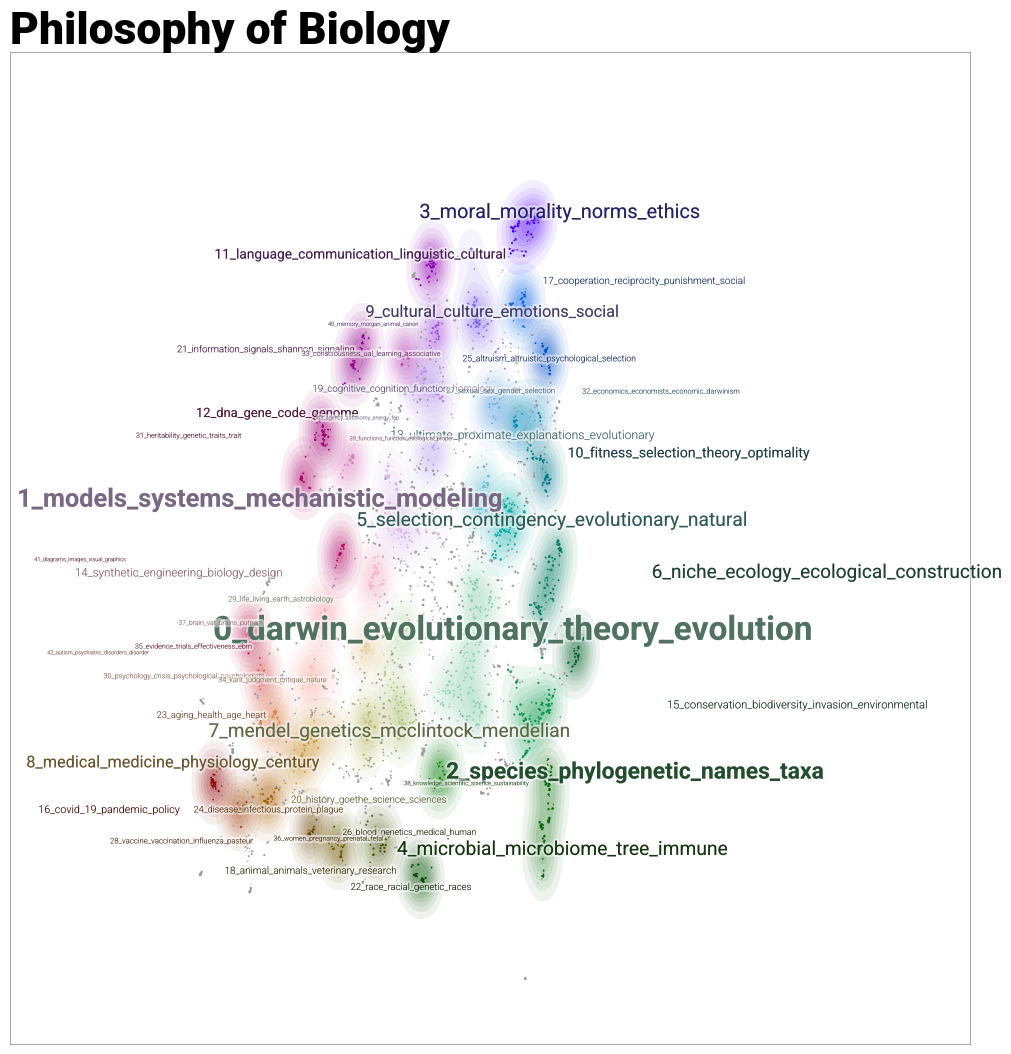

In [79]:
datamapplot.create_plot(
    reduced_embeddings,
    clean_labels,
    label_over_points=True, 
    dynamic_label_size=True,
    title = f"Philosophy of Biology",
    point_size=1, 
    marker_type="p", 
    marker_size_array= np.log(1 + newdf.citedby_count.values), 
    force_matplotlib=True
)

<InteractiveFigure width=100% height=800>
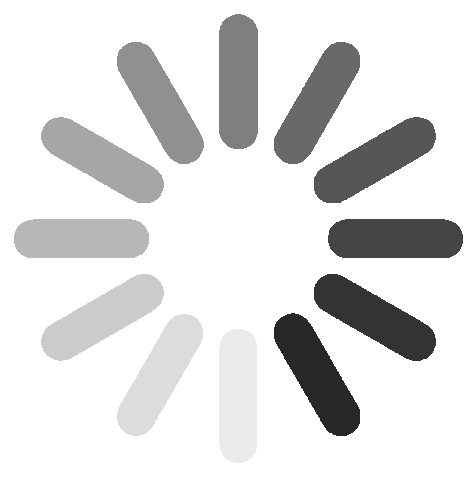

In [54]:
plot = datamapplot.create_interactive_plot(
    reduced_embeddings,
    clean_labels,
    hover_text = node_text,
    enable_search=True, 
    cluster_boundary_polygons=False,
    cluster_boundary_line_width=8,
    color_label_text=True,
    color_cluster_boundaries=False,
    inline_data=True,
    use_medoids = True,
    #background_color="#303446",
    title = f"Philosophy of Biology",  
    sub_title= f"From <i>Scopus</i>",
    polygon_alpha = 5,
    logo = "https://cirst.uqam.ca/wp-content/themes/cirst-theme/public/images/header/logo_complet.934102.png",

    )


plot



In [56]:
topic_model.get_document_info(docs)

Document  Topic  \
0     The article presents and critically discusses ...     16   
1     Charbonneau (2014) and Papale (2021) challenge...     -1   
2     In this paper, we consider whether a straightf...     13   
3     The concept of biological sex guides research,...     30   
4     Shared intentionality is key for understanding...     11   
...                                                 ...    ...   
3219  The Empiricist or Lockean view says natural ki...      2   
3220  The primary outcome of natural selection is ad...     -1   
3221  Accounts of the relation between theories and ...      1   
3222  Human propensities that are the products of Da...      4   
3223  I call an experiment "crucial" when it makes p...      6   

                                                   Name  \
0     16_conservation_biodiversity_invasion_environm...   
1              -1_biology_science_research_evolutionary   
2                               13_dna_gene_code_genome   
3                        30_sexual_sex_gender_selection   
4                  11_cultural_culture_social_evolution   
...                                                 ...   
3219                  2_species_phylogenetic_names_taxa   
3220           -1_biology_science_research_evolutionary   
3221              1_models_systems_mechanistic_modeling   
3222                      4_moral_morality_norms_ethics   
3223             6_mendel_genetics_mcclintock_mendelian   

                                         Representation  \
0     [conservation, biodiversity, invasion, environ...   
1     [biology, science, research, evolutionary, pap...   
2     [dna, gene, code, genome, genes, genetic, info...   
3     [sexual, sex, gender, selection, mate, female,...   
4     [cultural, culture, social, evolution, learnin...   
...                                                 ...   
3219  [species, phylogenetic, names, taxa, homology,...   
3220  [biology, science, research, evolutionary, pap...   
3221  [models, systems, mechanistic, modeling, biolo...   
3222  [moral, morality, norms, ethics, social, welfa...   
3223  [mendel, genetics, mcclintock, mendelian, expe...   

                                    Representative_Docs  \
0     [Among the instrumental value defenses for bio...   
1     [In this paper I characterize science in terms...   
2     [This paper examines a specific kind of part-w...   
3     [One of the explicit objectives of Darwin's De...   
4     [Cultural selection models aim to explain cult...   
...                                                 ...   
3219  [Biologists and philosophers have long recogni...   
3220  [In this paper I characterize science in terms...   
3221  [In this paper we draw upon rich ethnographic ...   
3222  [According to some recent arguments, (Joyce in...   
3223  [According to the traditional account Mendel's...   

                                            Top_n_words  Probability  \
0     conservation - biodiversity - invasion - envir...     0.650422   
1     biology - science - research - evolutionary - ...     0.000000   
2     dna - gene - code - genome - genes - genetic -...     0.989855   
3     sexual - sex - gender - selection - mate - fem...     0.815406   
4     cultural - culture - social - evolution - lear...     0.431372   
...                                                 ...          ...   
3219  species - phylogenetic - names - taxa - homolo...     1.000000   
3220  biology - science - research - evolutionary - ...     0.000000   
3221  models - systems - mechanistic - modeling - bi...     0.766800   
3222  moral - morality - norms - ethics - social - w...     0.411850   
3223  mendel - genetics - mcclintock - mendelian - e...     0.602455   

      Representative_document  
0                       False  
1                       False  
2                       False  
3                       False  
4                       False  
...                       ...  
3219                    False  
3220  

In [65]:
topic_labels = [
    "Unlabelled",
    "Darwinian Evolutionary Theory",
    "Mathematical Modeling Systems",
    "Phylogenetic Species Taxonomy",
    "Niche Ecological Communities",
    "Moral Ethics Framework",
    "Microbiome Host Interactions",
    "Mendelian Genetic Experiments",
    "Natural Selection Evolution",
    "Medical Physiology Research",
    "Cognitive Function Theory",
    "Fitness Selection Optimality",
    "Cultural Social Learning",
    "Language Communication Systems",
    "DNA Gene Expression",
    "Ultimate Proximate Explanation",
    "Synthetic Biology Engineering",
    "Conservation Biodiversity Protection",
    "COVID Pandemic Research",
    "History Science Philosophy",
    "Cooperation Reciprocity Networks",
    "Aging Health Medical",
    "Information Signaling Systems",
    "Animal Artifacts Agriculture",
    "Race Racial Genetics",
    "Economics Hamilton Theories",
    "Disease Infectious Protein",
    "Altruism Selection Psychology",
    "Blood Human Genetics",
    "Vaccine Influenza Research",
    "Psychology Crisis Trauma",
    "Sexual Gender Selection",
    "Kant Judgment Ethics",
    "Life Earth Origins",
    "Women Pregnancy Fetal",
    "Consciousness Learning Association",
    "Heritability Genetic Traits",
    "Evidence Clinical Trials",
    "Brain Human Neurons",
    "Perception Representation Sensory",
    "Diagrams Visual Graphics",
    "Autism Psychiatric Disorders",
    "Emotions Brain Processing",
    "Botanical Agricultural Plants",
    "Function Ecological Proper",
    "Development Morphogenetic Organisms",
    "Viruses Viral Life",
    "Knowledge Scientific Sustainability",
    "Variation Ecological Causal"
]

topic_labels

['Unlabelled',
 'Darwinian Evolutionary Theory',
 'Mathematical Modeling Systems',
 'Phylogenetic Species Taxonomy',
 'Niche Ecological Communities',
 'Moral Ethics Framework',
 'Microbiome Host Interactions',
 'Mendelian Genetic Experiments',
 'Natural Selection Evolution',
 'Medical Physiology Research',
 'Cognitive Function Theory',
 'Fitness Selection Optimality',
 'Cultural Social Learning',
 'Language Communication Systems',
 'DNA Gene Expression',
 'Ultimate Proximate Explanation',
 'Synthetic Biology Engineering',
 'Conservation Biodiversity Protection',
 'COVID Pandemic Research',
 'History Science Philosophy',
 'Cooperation Reciprocity Networks',
 'Aging Health Medical',
 'Information Signaling Systems',
 'Animal Artifacts Agriculture',
 'Race Racial Genetics',
 'Economics Hamilton Theories',
 'Disease Infectious Protein',
 'Altruism Selection Psychology',
 'Blood Human Genetics',
 'Vaccine Influenza Research',
 'Psychology Crisis Trauma',
 'Sexual Gender Selection',
 'Kant J

In [66]:
topic_info['Name_claude'] = topic_labels
topic_name = topic_info[["Name", "Name_claude"]]
topics_docs = topic_model.get_document_info(docs)

final_labels = pd.merge(topics_docs, topic_name, on='Name', how='left')
final_labels_legend = final_labels
final_labels = pd.array(final_labels.Name_claude)
final_labels

<NumpyExtensionArray>
['Conservation Biodiversity Protection',
                           'Unlabelled',
                  'DNA Gene Expression',
              'Sexual Gender Selection',
             'Cultural Social Learning',
 'Conservation Biodiversity Protection',
                           'Unlabelled',
                   'Life Earth Origins',
        'Mathematical Modeling Systems',
                           'Unlabelled',
 ...
       'Language Communication Systems',
               'Moral Ethics Framework',
                           'Unlabelled',
                           'Unlabelled',
        'Mendelian Genetic Experiments',
        'Phylogenetic Species Taxonomy',
                           'Unlabelled',
        'Mathematical Modeling Systems',
               'Moral Ethics Framework',
        'Mendelian Genetic Experiments']
Length: 3224, dtype: object

  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

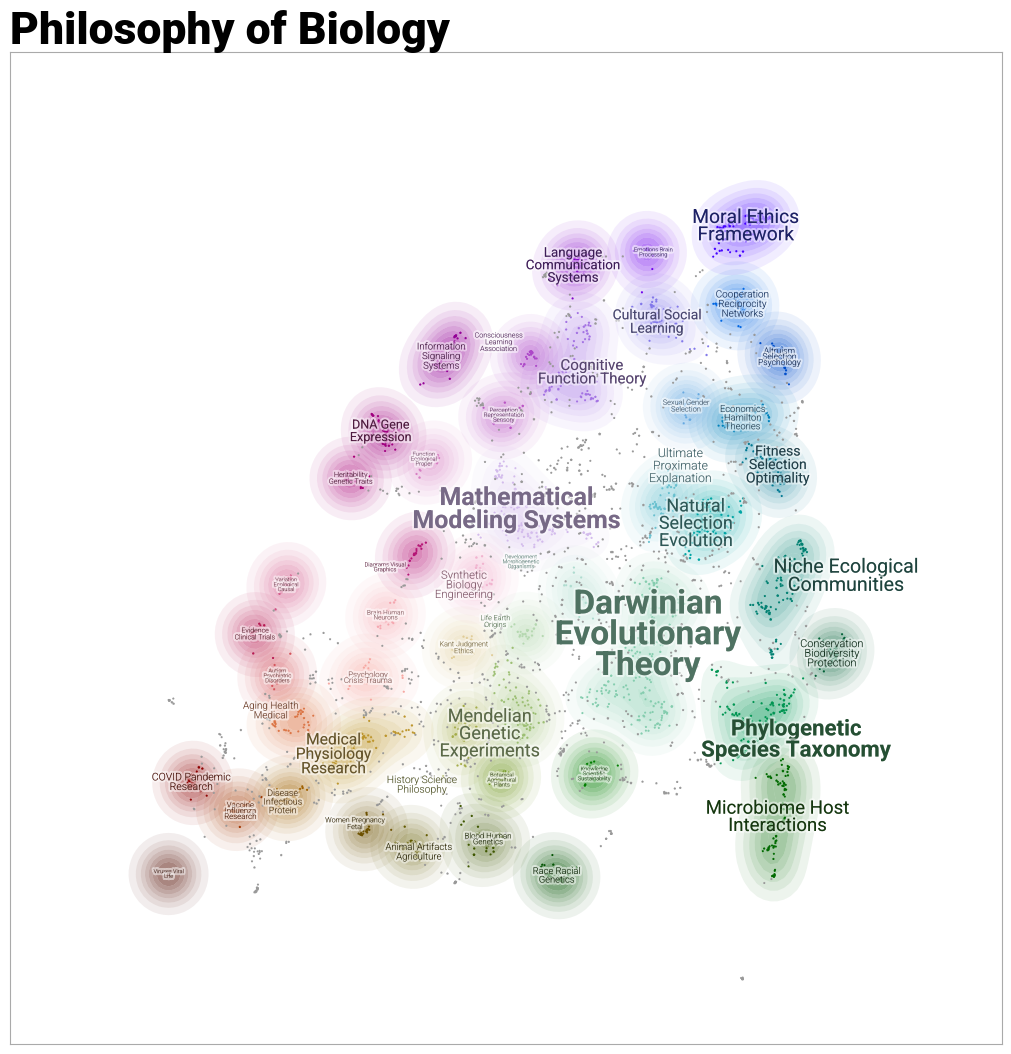

In [71]:
datamapplot.create_plot(
    reduced_embeddings,
    final_labels,
    label_over_points=True, 
    dynamic_label_size=True,
    title = f"Philosophy of Biology",
    point_size=1, 
    marker_type="p", 
    marker_size_array= np.log(20 + newdf.citedby_count.values), 
    force_matplotlib=True
)

<InteractiveFigure width=100% height=800>
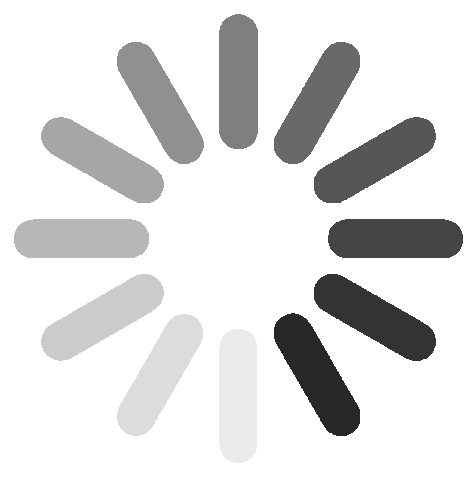

In [67]:
plot = datamapplot.create_interactive_plot(
    reduced_embeddings,
    final_labels,
    hover_text = node_text,
    enable_search=True, 
    cluster_boundary_polygons=False,
    cluster_boundary_line_width=8,
    color_label_text=True,
    color_cluster_boundaries=False,
    inline_data=True,
    use_medoids = True,
    #background_color="#303446",
    title = f"Philosophy of Biology",  
    polygon_alpha = 5,
    logo = "https://cirst.uqam.ca/wp-content/themes/cirst-theme/public/images/header/logo_complet.934102.png",

    )


plot


## Visualisation With Llama 

In [23]:
topic_model = BERTopic(
  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model, # this is the key line that changes. 
  vectorizer_model=vectorizer_model,
  
  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2025-04-21 15:17:38,829 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-21 15:17:48,908 - BERTopic - Dimensionality - Completed ✓
2025-04-21 15:17:48,910 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-21 15:17:48,998 - BERTopic - Cluster - Completed ✓
2025-04-21 15:17:49,003 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|          | 0/49 [00:28<?, ?it/s]


KeyboardInterrupt: 

  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'left': 'From Biology & Philosophy (1986-2022)'}>)

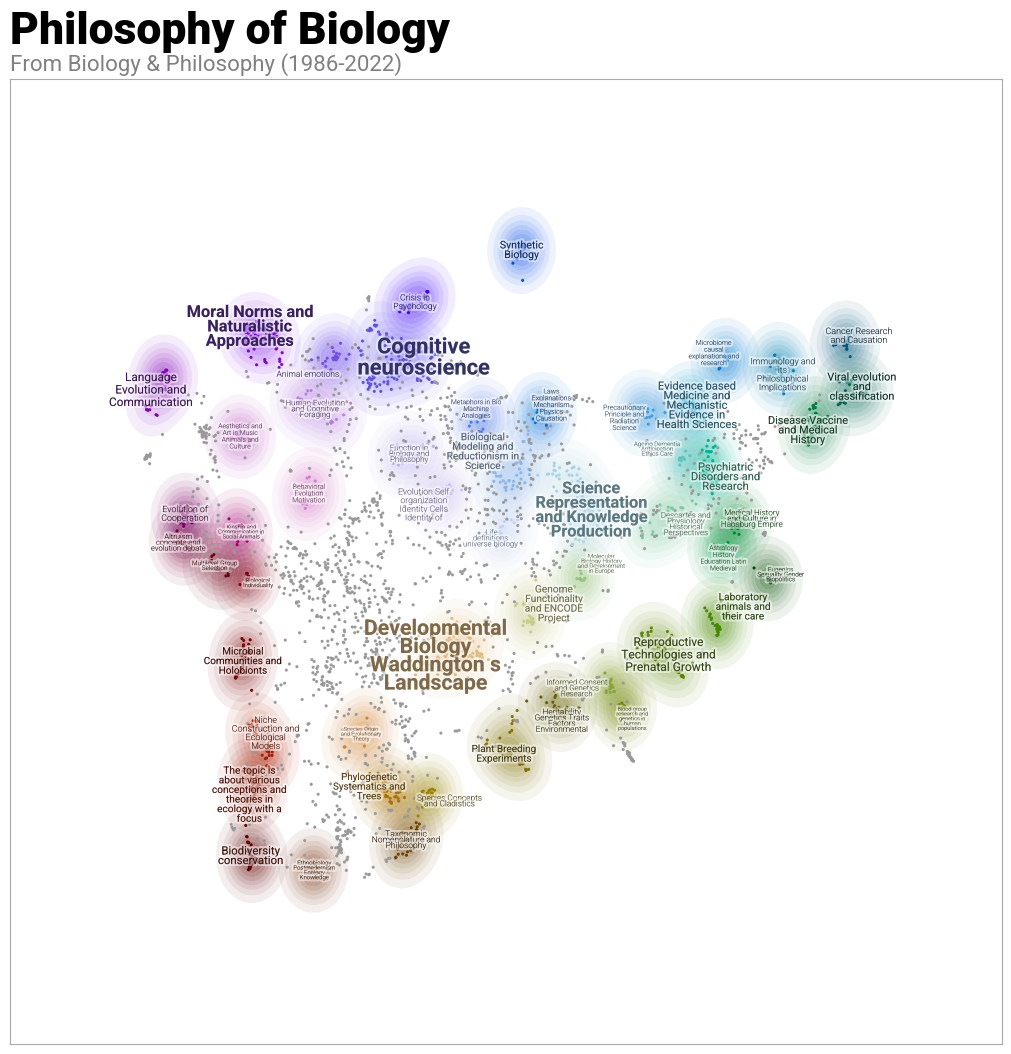

In [ ]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]


In [ ]:

datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_over_points=True, 
    dynamic_label_size=True,
    title = f"Philosophy of Biology",
    sub_title= f"From Biology & Philosophy (1986-2022)")




<InteractiveFigure width=100% height=800>
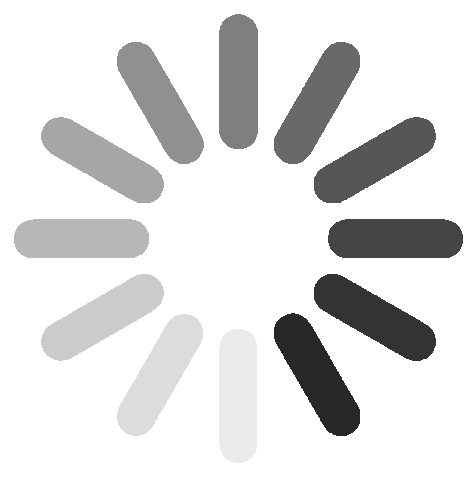

In [17]:
plot = datamapplot.create_interactive_plot(
    reduced_embeddings,
    all_labels,
    hover_text = node_text,
    enable_search=True, 
    cluster_boundary_polygons=False,
    cluster_boundary_line_width=8,
    color_label_text=True,
    color_cluster_boundaries=False,
    inline_data=True,
    use_medoids = True,
    #background_color="#303446",
    title = f"Philosophy of Biology",  
    sub_title= f"From <i>Biology & Philosophy</i> (1986-2022)",
    polygon_alpha = 5,
    logo = "https://cirst.uqam.ca/wp-content/themes/cirst-theme/public/images/header/logo_complet.934102.png",

    )


plot


In [18]:
timestamps = df.year.to_list()
topics_over_time = topic_model.topics_over_time(docs, timestamps)
topics_over_time


topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=3)


AttributeError: 'DataFrame' object has no attribute 'year'

In [2]:
pip install flair

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.2 MB ? eta -:--:--
   -------------------------- ------------- 0.8/1.2 MB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 2.0 MB/s eta 0:00:00
  Created wheel for pptree: filename=pptree-3.1-py3-none-any.whl size=4614 sha256=3161cfd1cfee222f049a4fc18fb041f5efcac6b4b937375d68c537201a897d46
  Stored in directory: c:\users\jacob\appdata\local\p

In [12]:
from flair.embeddings import TransformerDocumentEmbeddings
from adapters import AutoAdapterModel
model = AutoAdapterModel.from_pretrained("allenai/specter_plus_plus")
model.load_adapter("allenai/specter2", set_active=True)

specter2 = TransformerDocumentEmbeddings()
topic_model = BERTopic(embedding_model=roberta)

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

c:\Users\jacob\anaconda3\envs\test\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jacob\.cache\huggingface\hub\models--allenai--specter_plus_plus. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/717k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\jacob\anaconda3\envs\test\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jacob\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

NameError: name 'BERTopic' is not defined